In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow.keras.backend as K

from sificc_lib import AI, utils, Event, Simulation, root_files, DataModel
np.set_printoptions(precision=2, linewidth=85, suppress=True)

%matplotlib inline

In [2]:
# model name
model_name = 'model-2b-lsr'

shuffle_clusters = False

# load the training data
data = DataModel('data-enough-8cl.npz', 
                 batch_size = 128, validation_percent = .05, test_percent = .1)

# append an extra dimention to the features since we are using convolutional layers
data.append_dim = True

# create an AI instance
ai = AI(data, model_name)

ai.weight_type = 2
ai.weight_pos_x = 2.5
ai.weight_pos_y = 1
ai.weight_pos_z = 2
ai.weight_energy = 1.5
ai.weight_e_cluster = 1
ai.weight_p_cluster = 1

# randomly shuffle the training data
#np.random.seed(888)
#ai.data.shuffle(only_train=False)

# shuffle the clusters within each event
if shuffle_clusters:
    ai.data.shuffle_training_clusters()

In [3]:
# define and create the neural network architecture
ai.create_model(conv_layers=[128, 64], classifier_layers=[32], type_layers=[8], 
                pos_layers=[64,32], energy_layers=[32, 16], base_l2=.0001, limbs_l2=.0001)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 72, 1)]      0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 8, 128)       1280        inputs[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 8, 64)        8256        conv_1[0][0]                     
__________________________________________________________________________________________________
flatting (Flatten)              (None, 512)          0           conv_2[0][0]                     
______________________________________________________________________________________________

In [4]:
# compile the ai
ai.compile_model(learning_rate=0.0003)

# define the learning rate scheduler for the training phase
def lr_scheduler(epoch):
    if epoch < 90:
        return .0003
    elif epoch < 160:
        return .0001
    elif epoch < 180:
        return .00003
    elif epoch < 190:
        return .00001
    else:
        return .000003
l_callbacks = [
    keras.callbacks.LearningRateScheduler(lr_scheduler),
]

In [5]:
#LOADING
ai.load(model_name, optimizer=False)
ai.compile_model()

In [5]:
#TRAINING

In [6]:
%%time
# start the training
#ai.train(epochs=200, shuffle=True, shuffle_clusters=shuffle_clusters, verbose=0, callbacks = l_callbacks)

# evaluate the AI on the training set
#ai.model.evaluate(ai.data.train_x, ai.data.train_y, verbose=1)
#print()

17443/17443 [==============================] - 67s 4ms/step - loss: 3.5529 - e_cluster_loss: 0.0307 - p_cluster_loss: 0.0764 - type_loss: 0.2733 - pos_x_loss: 0.0393 - pos_y_loss: 1.1009 - pos_z_loss: 0.0452 - energy_loss: 1.0079 - e_cluster__cluster_accuracy: 0.9570 - p_cluster__cluster_accuracy: 0.8936 - type__type_accuracy: 0.8829 - type__type_tp_rate: 0.8366

CPU times: user 22h 3min 46s, sys: 9min 15s, total: 22h 13min 1s
Wall time: 22h 15min 57s


In [6]:
# evaluate the AI on the test dataset
ai.evaluate()

AI model
  Loss:        3.45655
    -Type:         0.27309 *  2.00 = 0.54619
    -Pos X:        0.03541 *  2.50 = 0.08854
    -Pos Y:        1.08336 *  1.00 = 1.08336
    -Pos Z:        0.04034 *  2.00 = 0.08067
    -Energy:       0.96894 *  1.50 = 1.45340
    -Cls e:        0.03097 *  1.00 = 0.03097
    -Cls p:        0.07578 *  1.00 = 0.07578
  Accuracy:    0.88271
    -TP rate:      0.83581
    -Cls e rate:   0.95581
    -Cls p rate:   0.89239
  Efficiency:  0.18246
  Purity:      0.16736
  Euc mean:   11.10979
  Euc std:    29.15231

Reco
  Accuracy:    0.64432
    -TP rate:      0.75151
  Efficiency:  0.12849
  Purity:      0.07249
  Euc mean:   20.92661
  Euc std:    49.07857


In [9]:
# save the trained model
#ai.save(file_name=model_name)

In [7]:
# Filter and biases of first conv (1D) layer
filters, biases = ai.model.layers[1].get_weights()

In [8]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

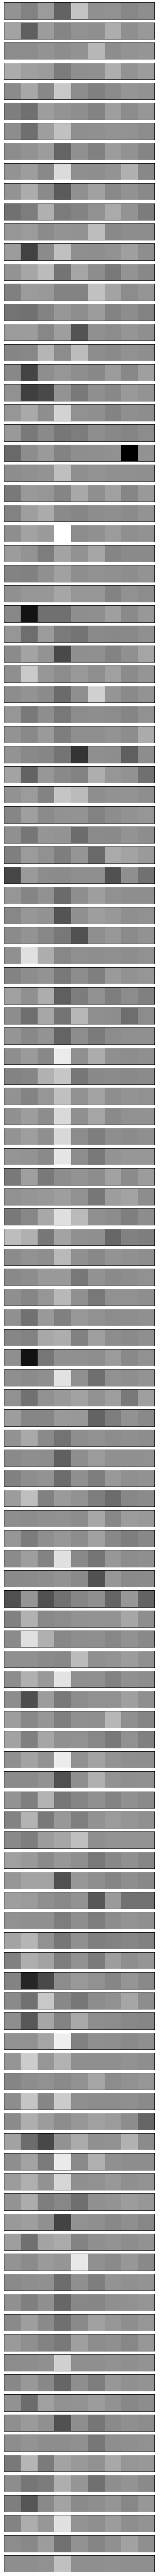

In [9]:
# Plotting filters of the convolutional layer

n_filters, ix = 128,1
fig1 = plt.figure(figsize=(10,128))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, i]
    # plot each channel separately
    for j in range(1):
        ax = fig1.add_subplot(n_filters, 1, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        ff = f[:, j]
        f_expand = np.expand_dims(ff,axis=0)
        # plot filter channel in grayscale
        plt.imshow(f_expand, cmap='gray')
        plt.clim(0,1)
        ix += 1
plt.show()
plt.close()

# Nine filter channels per event
# Filters are applied to input data (features)
# Dark = small weights, light = larger weights

In [15]:
# New model which predicts the outputs of the conv1D layr
model_conv_output = keras.models.Model(inputs=ai.model.inputs, outputs=ai.model.layers[1].output)

In [11]:
# Prediction on single event from test data set
feature_maps = model_conv_output.predict(ai.data.test_x[:1])
print('Shape of feature_maps: ')
feature_maps.shape

Shape of feature_maps: 


(1, 8, 128)

In [23]:
# Showed event: last three clusters contain zeros
#print(ai.data.test_x[:1])

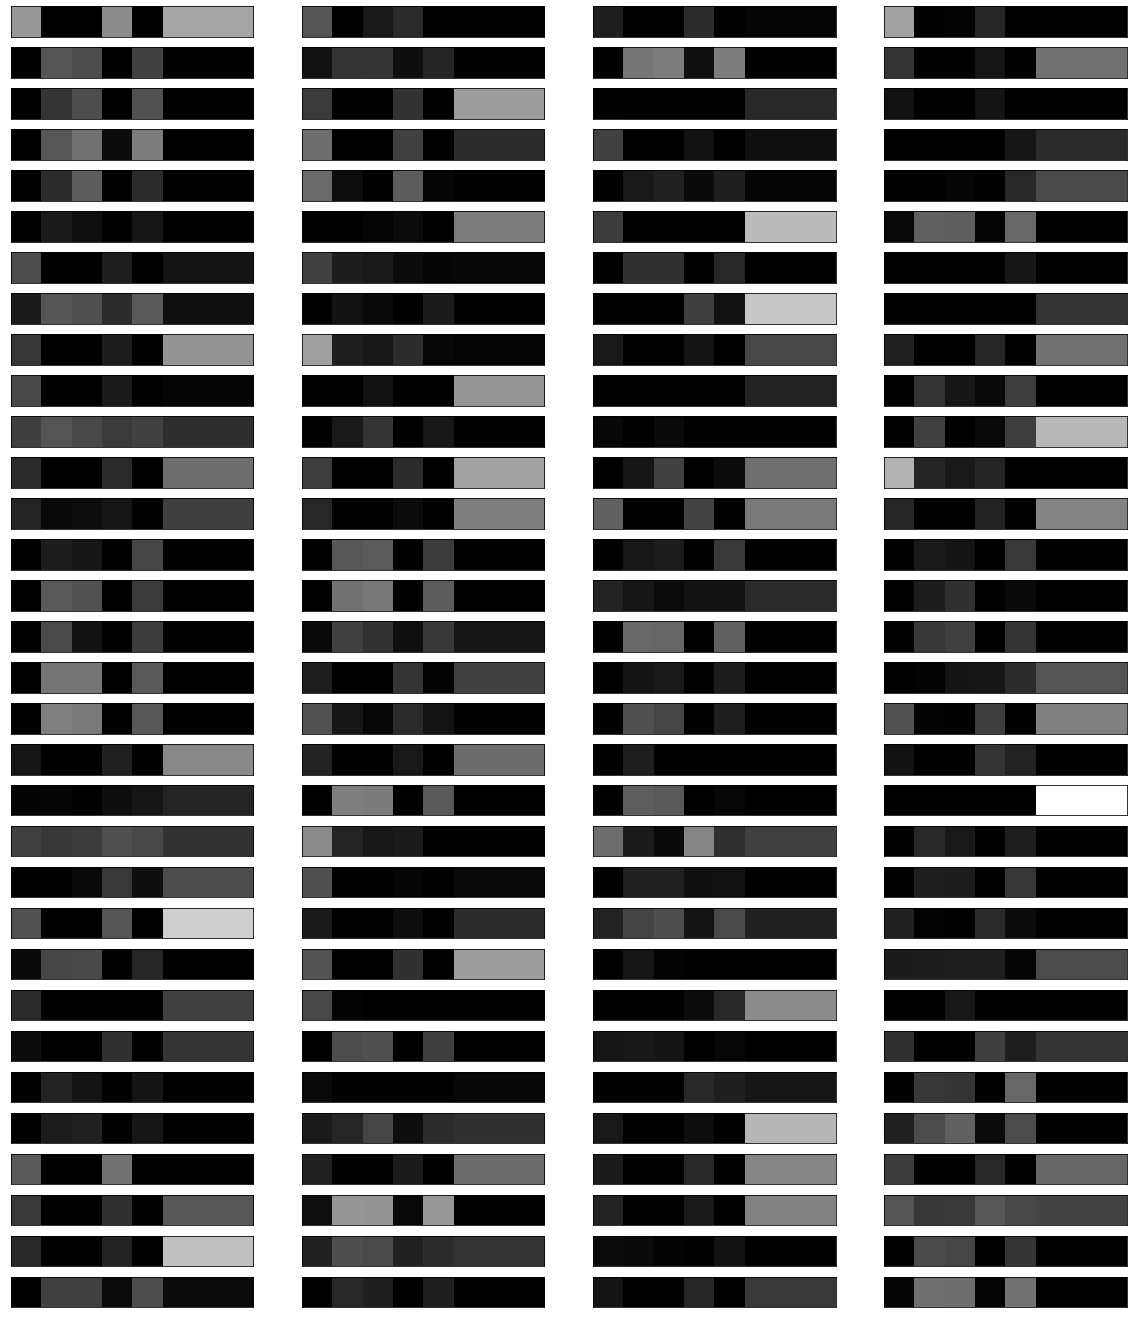

In [12]:
# Feature output maps of first convolutional layer, for a given event
square1 = 32
square2 = 4
ix = 1
fig1 = plt.figure(figsize=(20,24))
for _ in range(square1):
    for _ in range(square2):
        # specify subplot and turn of axis
        ax = fig1.add_subplot(square1, square2, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        #print(feature_maps[0, :, ix-1])
        fm_expand = np.expand_dims(feature_maps[0, :, ix-1], axis=0)
        plt.imshow(fm_expand, cmap='gray')
        plt.clim(np.amin(feature_maps[0]),np.amax(feature_maps[0]))
        ix += 1
        # show the figure
plt.show()
# Feature map visualization for prediction of trained model on test data point

In [13]:
# Prediction on training data set
# New model which predicts the outputs of the conv1D layer
feature_maps_train = model_conv_output.predict(ai.data.get_features(0,1))

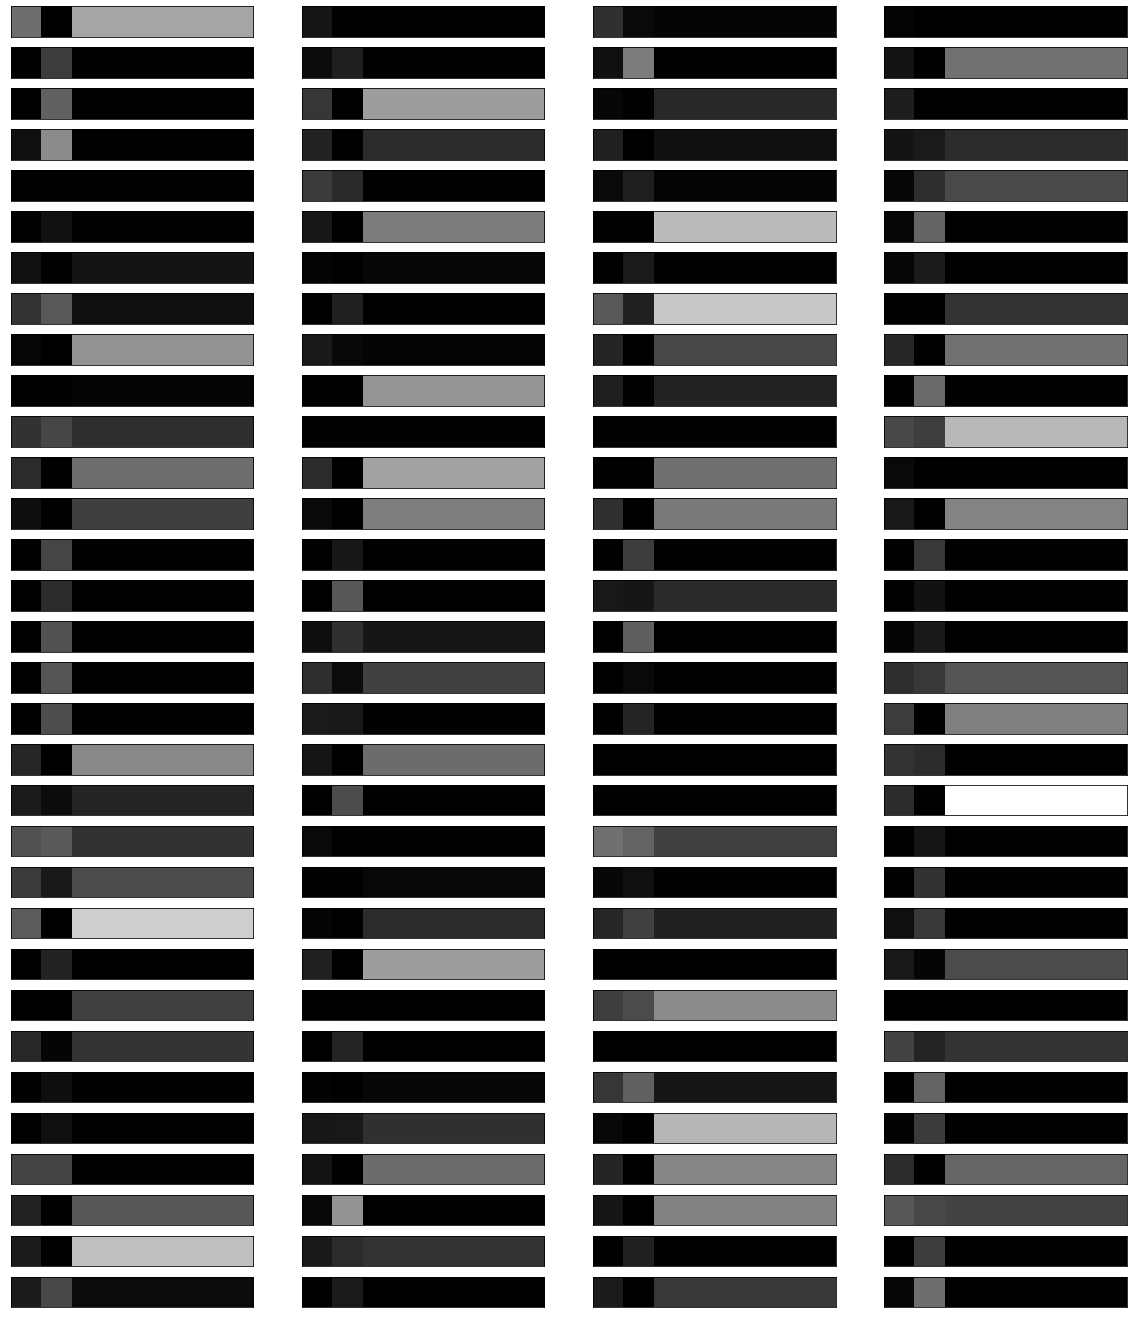

In [14]:
# Feature output maps of first convolutional layer, for a given event
square1 = 32
square2 = 4
ix = 1
fig1 = plt.figure(figsize=(20,24))
for _ in range(square1):
    for _ in range(square2):
        # specify subplot and turn of axis
        ax = fig1.add_subplot(square1, square2, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        #print(feature_maps[0, :, ix-1])
        fm_expand = np.expand_dims(feature_maps_train[0, :, ix-1], axis=0)
        plt.imshow(fm_expand, cmap='gray')
        plt.clim(np.amin(feature_maps_train[0]),np.amax(feature_maps_train[0]))
        ix += 1

plt.show()

# Feature map for prediction with trained model 
# on training data set data point
# Eight channels
    # No of clusters, Cl energy, Cluster energy uncertainty
    # Cl pos x y z , Cl pos uncertainty x y z